# Life Expectancy Data Science Project

---------------

### Introduction
This analysis explores a life expectancy dataset, aiming to uncover factors affecting life expectancy across countries over time. We'll handle missing values, engineer features, perform exploratory analysis, visualize patterns, and build a regression model to predict life expectancy.

### Objectives
- Understand the structure and quality of the dataset
- Identify key features affecting life expectancy
- Handle missing data appropriately
- Engineer new features to improve prediction
- Visualize relationships and trends
- Build a regression model to predict life expectancy
- Evaluate model performance using cross-validation
- Derive actionable insights

### Task 1: Explore Dataset and Missing Values

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize
import re
from scipy.stats import median_abs_deviation

In [3]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.shape 

(1649, 22)

In [4]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                      int64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                          int64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                                int64
Total expenditure                  float64
Diphtheria                           int64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [5]:
df.dtypes.value_counts()

float64    12
int64       8
object      2
Name: count, dtype: int64

In [6]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [7]:

for column in df.columns:
    # Remove leading/trailing spaces and compress multiple spaces into single spaces
    cleaned_column = re.sub(r'\s+', ' ', column.strip())
    df.rename(columns={column: cleaned_column}, inplace=True)

df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness 1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [8]:
df.head(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,...,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,...,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,...,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,...,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,...,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,...,66,9.20,66,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281,77,0.01,56.762217,63,2861,...,63,9.42,63,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287,80,0.03,25.873925,64,1599,...,64,8.33,64,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295,82,0.02,10.910156,63,1141,...,63,6.73,63,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295,84,0.03,17.171518,64,1990,...,58,7.43,58,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [9]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool


In [10]:
#Find total of duplicated values
print(df.duplicated().sum())

0


In [11]:
# Get the number of unique countries from the 'Country' column
number_of_countries = df['Country'].nunique()

# Print the number of unique countries
print(f"The total number of unique countries in the dataset is: {number_of_countries}")

The total number of unique countries in the dataset is: 133


### Task 2: Handle Missing Data and Justify Method

In [12]:
null_values = df.isnull().sum()

In [13]:
#Checks if any column has NaN
df.isnull().any()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness 1-19 years                False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [14]:
#Checks if any row has NaN
df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [15]:
#Checks if all values in a column are NaN
df.isnull().all()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness 1-19 years                False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [16]:
#Checks if all values in a row are NaN
df.isnull().all(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [ ]:
# Percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df))*100
print(null_percentage)

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness 1-19 years                0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64


In [ ]:
# Create a DataFrame to summarize missing values
missing_df = pd.DataFrame({'Missing Values': null_values, 'Percent Missing': null_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percent Missing


### Advanced mechanisms to handle missing data

#### Outlier detection
1. Z-Score

In [ ]:

# Initialize tracker
outlier_indices_per_column = {col: set() for col in df.select_dtypes(include='number').columns}

# Z-Score function
def detect_outliers(series, threshold=3.5):
    median = series.median()
    mad = median_abs_deviation(series, scale='normal')  # scaled to be comparable to std
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    z_scores = 0.6745 * (series - median) / mad
    return abs(z_scores) > threshold

# Process per country
for country, group in df.groupby('Country'):
    for col in df.select_dtypes(include='number').columns:
        is_outlier = detect_outliers(group[col])
        outlier_indices_per_column[col].update(group[is_outlier].index)

# summary table
summary = []
for col, indices in outlier_indices_per_column.items():
    count = len(indices)
    summary.append({
        'Column': col,
        'Outlier Count': count,
        'Percentage': round((count / len(df)) * 100, 2)
    })

# DataFrame and  results ===
outlier_summary = pd.DataFrame(summary).sort_values(by='Outlier Count', ascending=False)

print("Outlier Detection Summary (Z-Score per Country, Unique Rows Only)")
print("=" * 70)
print(outlier_summary.to_string(index=False))


Outlier Detection Summary (Z-Score per Country, Unique Rows Only)
                         Column  Outlier Count  Percentage
                     Population            390       23.65
                        Measles            180       10.92
                Adult Mortality            174       10.55
                            BMI            151        9.16
                    Hepatitis B            134        8.13
                     Diphtheria            113        6.85
                          Polio            106        6.43
                        Alcohol             92        5.58
              Total expenditure             43        2.61
         percentage expenditure             43        2.61
                            GDP             35        2.12
Income composition of resources             32        1.94
                Life expectancy             25        1.52
            thinness 1-19 years             24        1.46
             thinness 5-9 years             23   

2. Box plot

C:\Users\user\AppData\Local\Temp\ipykernel_9116\2283595958.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:\Users\user\AppData\Local\Temp\ipykernel_9116\2283595958.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
C:

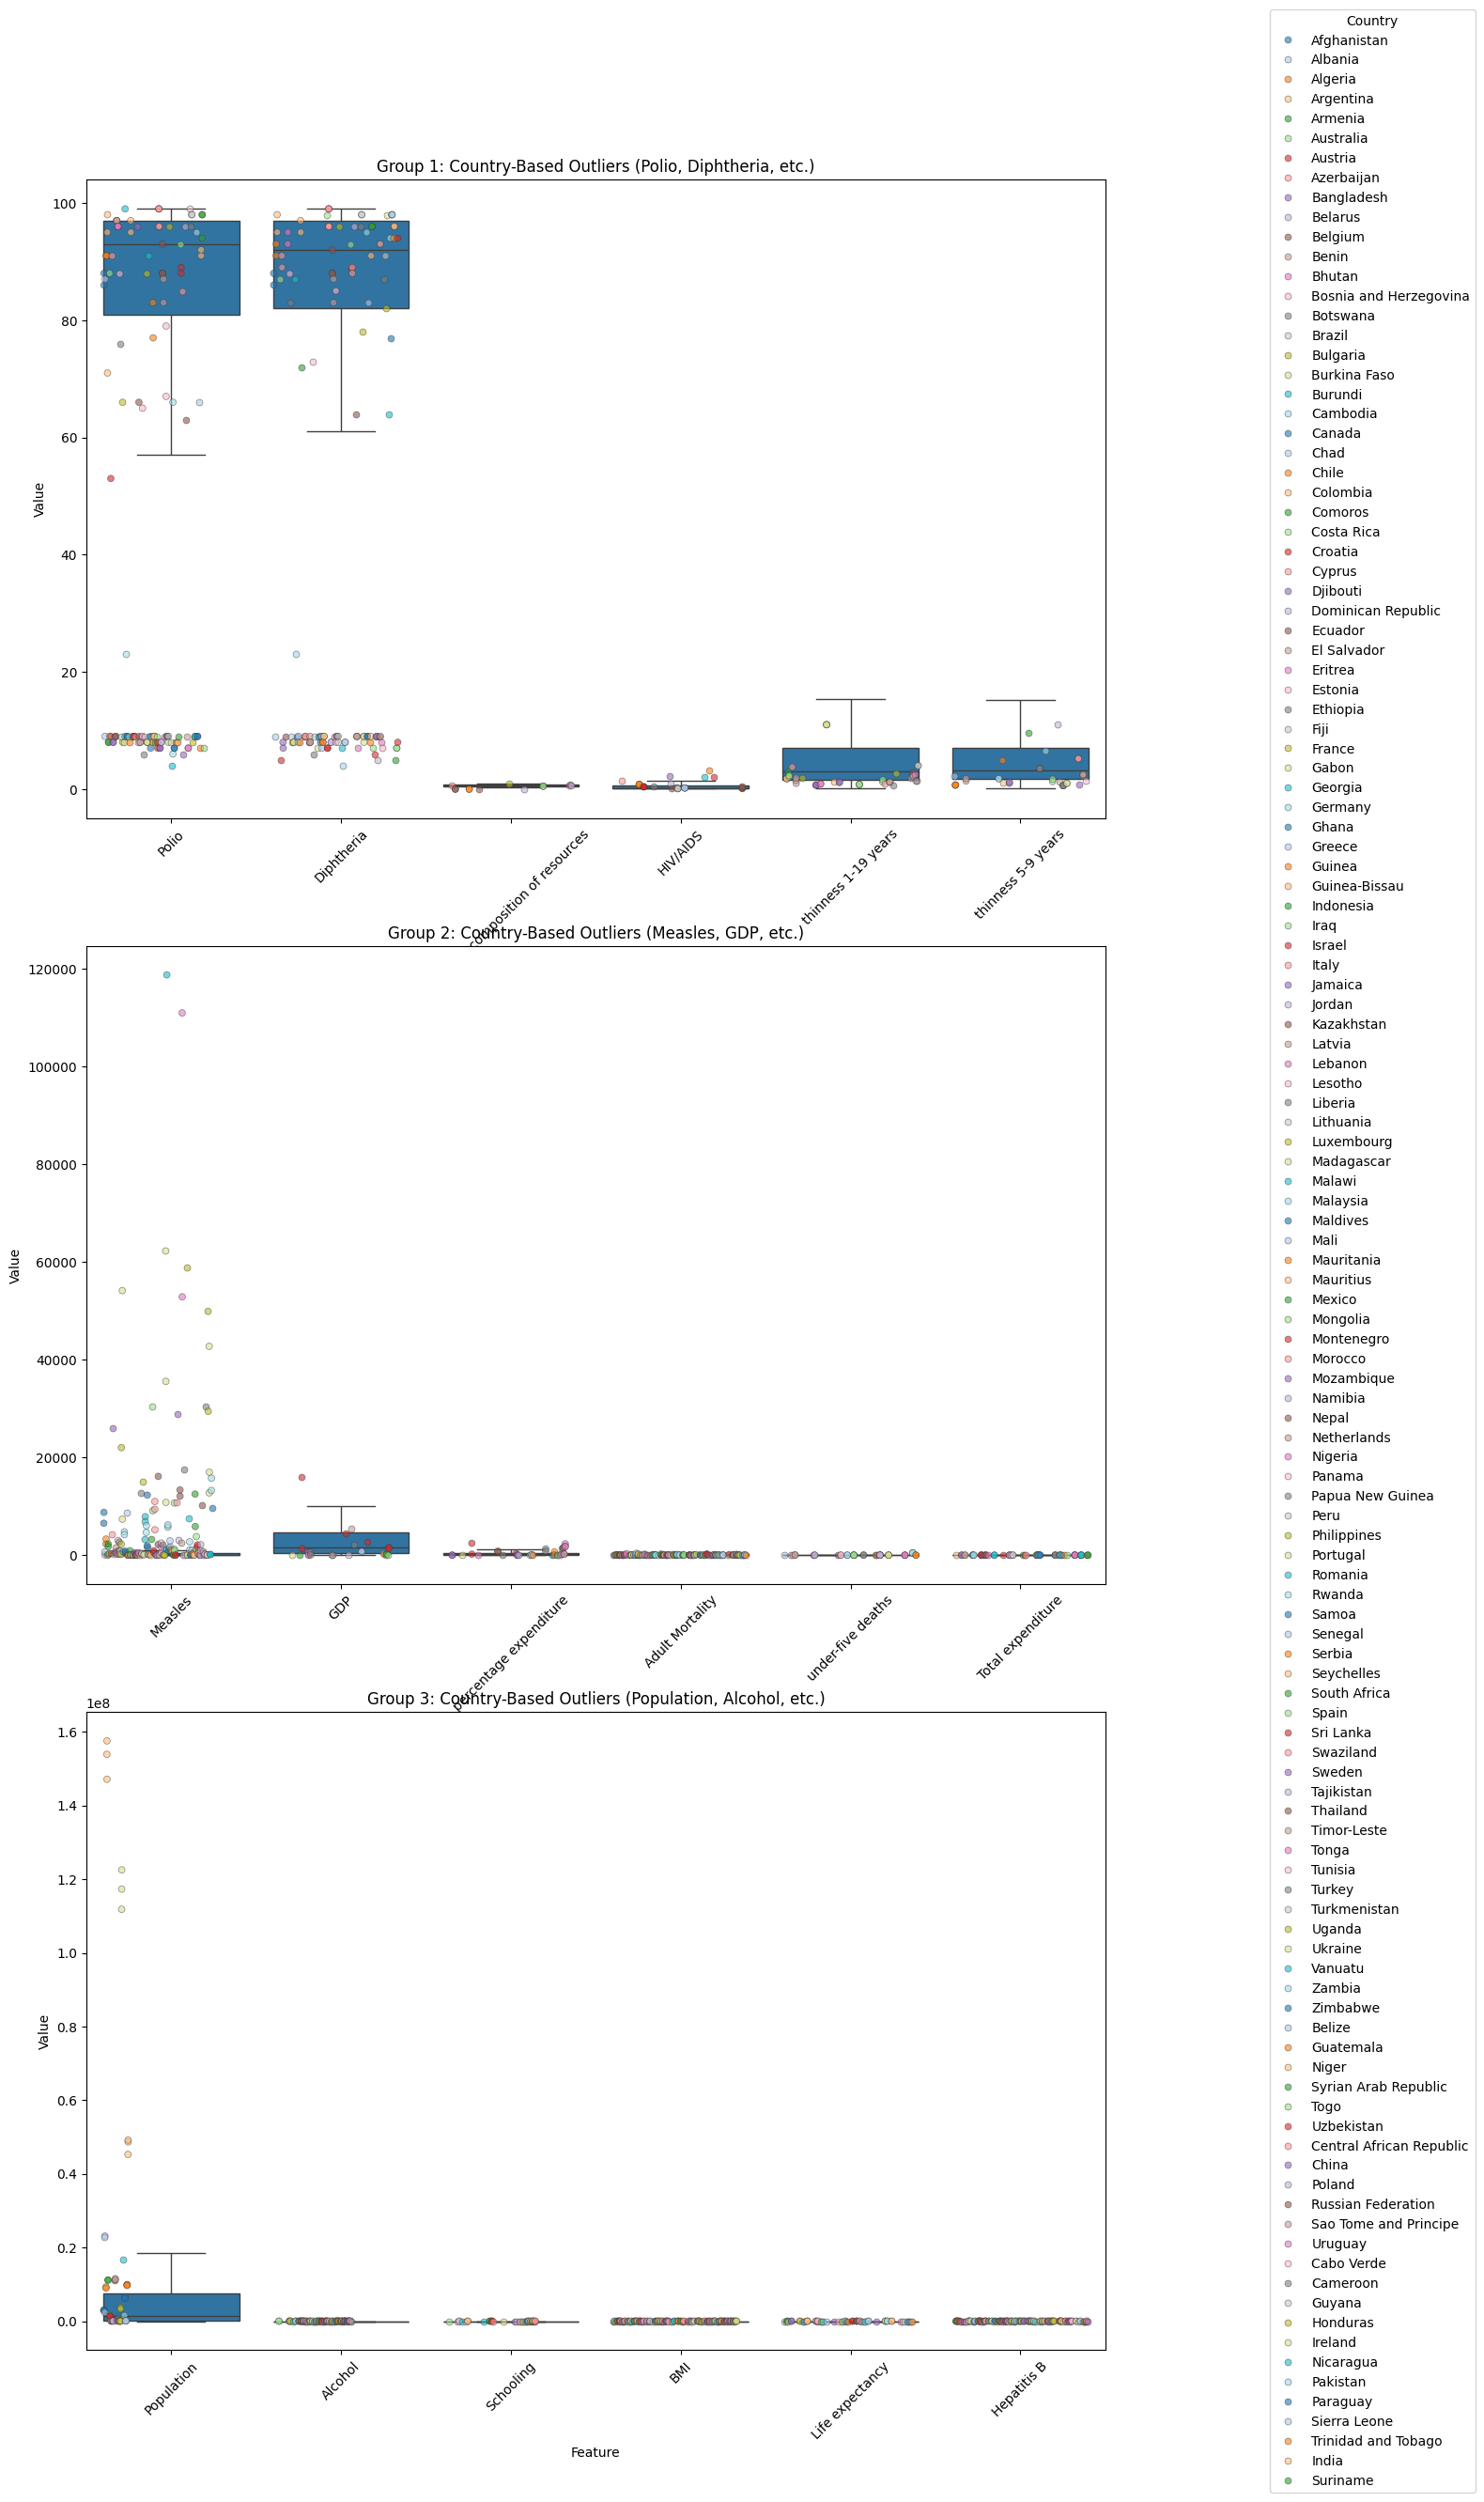

In [ ]:
# === First feature group ===
features_1 = ['Polio', 'Diphtheria', 'Income composition of resources',
              'HIV/AIDS', 'thinness 1-19 years', 'thinness 5-9 years']

# === Second feature group ===
features_2 = ['Measles', 'GDP', 'percentage expenditure', 'Adult Mortality', 'under-five deaths', 'Total expenditure']

features_3 = ['Population', 'Alcohol', 'Schooling', 'BMI', 'Life expectancy', 'Hepatitis B']

# === Prepare melted data for both groups ===
def melt_and_tag_outliers(df, features):
    melted = df[['Country'] + features].melt(id_vars='Country', var_name='Feature', value_name='Value')

    def detect_and_tag_outliers(group):
        q1 = group['Value'].quantile(0.25)
        q3 = group['Value'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        group['Outlier'] = (group['Value'] < lower) | (group['Value'] > upper)
        return group

    tagged = melted.groupby(['Country', 'Feature'], group_keys=False).apply(detect_and_tag_outliers)
    return tagged

df_tagged_1 = melt_and_tag_outliers(df, features_1)
df_tagged_2 = melt_and_tag_outliers(df, features_2)
df_tagged_3 = melt_and_tag_outliers(df, features_3)

# === Create subplots ===
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 30))  # reduce figure height


# --- Plot 1 ---
sns.boxplot(data=df_tagged_1, x='Feature', y='Value', showfliers=False, ax=ax1)
sns.stripplot(
    data=df_tagged_1[df_tagged_1['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax1
)
ax1.set_title("Group 1: Country-Based Outliers (Polio, Diphtheria, etc.)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend_.remove()


# --- Plot 2 ---
sns.boxplot(data=df_tagged_2, x='Feature', y='Value', showfliers=False, ax=ax2)
sns.stripplot(
    data=df_tagged_2[df_tagged_2['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax2
)
ax2.set_title("Group 2: Country-Based Outliers (Measles, GDP, etc.)")
ax2.tick_params(axis='x', rotation=45)

ax2.legend_.remove()

# --- Plot 3 ---
sns.boxplot(data=df_tagged_3, x='Feature', y='Value', showfliers=False, ax=ax3)
sns.stripplot(
    data=df_tagged_3[df_tagged_3['Outlier']],
    x='Feature',
    y='Value',
    hue='Country',
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.6,
    linewidth=0.5,
    edgecolor='gray',
    palette='tab20',
    ax=ax3
)
ax3.set_title("Group 3: Country-Based Outliers (Population, Alcohol, etc.)")
ax3.tick_params(axis='x', rotation=45)
ax3.legend_.remove()


# === Add legend outside the full figure ===
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title='Country', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.show()


### Implementation of Data handling 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# === Load dataset ===
try:
    df = pd.read_csv("Life_Expectancy_Data.csv")
    df.columns = df.columns.str.strip()
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'Life_Expectancy_Data.csv' not found.")
    exit()

# === Define feature categories ===
# These will use percentile-based capping due to skewness
skewed_features = ['Adult Mortality']
# These will use IQR capping
iqr_features = ['Polio', 'Diphtheria', 'Hepatitis B',
                'Total expenditure', 'percentage expenditure']
# These will use log transformation
log_transform_features = ['Measles', 'Population', 'Alcohol']


# All features to process
all_features = skewed_features + iqr_features + log_transform_features 

# === Impute missing values using country-wise median ===
print("🔧 Imputing missing values with country-wise median...")
for col in all_features:
    if col in df.columns:
        df[col] = df.groupby('Country')[col].transform(lambda x: x.fillna(x.median()))
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
print("Imputation complete.")

# === Helper Functions ===

def percentile_cap_grouped(df, col, lower=0.01, upper=0.99):
    """Apply percentile capping per country."""
    def cap(x):
        return x.clip(lower=x.quantile(lower), upper=x.quantile(upper))
    return df.groupby("Country")[col].transform(cap)

def iqr_cap_grouped(df, col):
    """Apply IQR capping per country."""
    def cap(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or x.isnull().all():
            return x
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return x.clip(lower, upper)
    return df.groupby("Country")[col].transform(cap)

def apply_log_transform_safely(x):
    """Log transform safely, avoiding log(0)."""
    return np.log1p(x.clip(lower=0))

# === Apply transformations ===
print("\nApplying transformations and tracking changes...")
df_cleaned = df.copy()
changes_summary = {}

# 1. Percentile Capping → skewed features
for col in skewed_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = percentile_cap_grouped(df_cleaned, col)
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ Percentile Capped → {col}: {changes_summary[col]} values modified")

# 2. IQR Capping → other features
for col in iqr_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = iqr_cap_grouped(df_cleaned, col)
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ IQR Capped → {col}: {changes_summary[col]} values modified")

# 3. Log Transform → log_transform_features
for col in log_transform_features:
    if col in df_cleaned.columns:
        before = df_cleaned[col].copy()
        df_cleaned[col] = apply_log_transform_safely(df_cleaned[col])
        changes_summary[col] = (df_cleaned[col] != before).sum()
        print(f"✔ Log Transformed → {col}: {changes_summary[col]} values modified")

# === Save cleaned dataset ===
final_cols = ['Country', 'Year', 'Life expectancy'] + all_features
final_cols = [col for col in final_cols if col in df_cleaned.columns]
df_final = df_cleaned[final_cols]
df_final.to_csv("Cleaned_Life_Expectancy_Countrywise_Final.csv", index=False)

# === Summary ===
print("Final Summary of Outlier Handling:")
for col, count in changes_summary.items():
    if col in skewed_features:
        method = "Percentile Capped"
    elif col in iqr_features:
        method = "IQR Capped"
    else:
        method = "Log Transformed"
    print(f"✔ {method} → {col}: {count} values modified")

print("\n📁 Cleaned dataset saved as: Cleaned_Life_Expectancy_Countrywise_Final.csv")


Dataset loaded successfully.
🔧 Imputing missing values with country-wise median...
Imputation complete.

Applying transformations and tracking changes...
✔ Percentile Capped → Adult Mortality: 238 values modified
✔ IQR Capped → Polio: 130 values modified
✔ IQR Capped → Diphtheria: 122 values modified
✔ IQR Capped → Hepatitis B: 156 values modified
✔ IQR Capped → Total expenditure: 60 values modified
✔ IQR Capped → percentage expenditure: 35 values modified
✔ Log Transformed → Measles: 1095 values modified
✔ Log Transformed → Population: 1649 values modified
✔ Log Transformed → Alcohol: 1649 values modified
Final Summary of Outlier Handling:
✔ Percentile Capped → Adult Mortality: 238 values modified
✔ IQR Capped → Polio: 130 values modified
✔ IQR Capped → Diphtheria: 122 values modified
✔ IQR Capped → Hepatitis B: 156 values modified
✔ IQR Capped → Total expenditure: 60 values modified
✔ IQR Capped → percentage expenditure: 35 values modified
✔ Log Transformed → Measles: 1095 values mod

In [ ]:
# Handling missing values for BMI separately

# --- Step 1: Identify invalid BMI values ---
invalid_bmi_mask = (df['BMI'] < 15) | (df['BMI'] > 40)
num_bmi_replaced = invalid_bmi_mask.sum()

# --- Step 2: Replace invalid values with NaN ---
df['BMI'] = df['BMI'].mask(invalid_bmi_mask, np.nan)

# --- Step 3: Impute missing BMI values using MICE based on Life expectancy ---
imputer = IterativeImputer(random_state=42)
# Select relevant columns for MICE
imputed_values = imputer.fit_transform(df[['Life expectancy', 'BMI']])
df[['Life expectancy', 'BMI']] = imputed_values

# --- Step 4: Extract cleaned BMI data ---
cleaned_bmi_df = df[['Country', 'Year', 'BMI']].copy()

# --- Output Summary ---
print(f"{num_bmi_replaced} invalid BMI values were replaced with NaN and imputed using MICE.")
print("\nCleaned BMI Dataset (Sample):")
print(cleaned_bmi_df.head(10))

# Optional: Save to CSV
cleaned_bmi_df.to_csv("cleaned_bmi_data.csv", index=False)

1092 invalid BMI values were replaced with NaN and imputed using MICE.

Cleaned BMI Dataset (Sample):
       Country  Year       BMI
0  Afghanistan  2015  19.10000
1  Afghanistan  2014  18.60000
2  Afghanistan  2013  18.10000
3  Afghanistan  2012  17.60000
4  Afghanistan  2011  17.20000
5  Afghanistan  2010  16.70000
6  Afghanistan  2009  16.20000
7  Afghanistan  2008  15.70000
8  Afghanistan  2007  15.20000
9  Afghanistan  2006  23.27624


In [ ]:
# --- Step 0: Initial State ---
print("\n--- Initial State of GDP Column ---")
initial_missing_gdp = df['GDP'].isnull().sum()
print(f"Number of missing GDP values initially: {initial_missing_gdp}")

# --- Step 1: Detect Outliers on a Per-Country Basis ---
print("\n--- Step 1: Detecting Outliers for Each Country Individually ---")

def get_country_upper_bound(series):
    q3 = series.quantile(0.75)
    iqr = q3 - series.quantile(0.25)
    return q3 + 1.5 * iqr

def get_country_lower_bound(series):
    q1 = series.quantile(0.25)
    iqr = series.quantile(0.75) - q1
    iqr_lower_bound = q1 - 1.5 * iqr
    domain_lower_bound = 100.0
    return max(iqr_lower_bound, domain_lower_bound)

# Apply outlier bounds per country
country_upper_bounds = df.groupby('Country')['GDP'].transform(get_country_upper_bound)
country_lower_bounds = df.groupby('Country')['GDP'].transform(get_country_lower_bound)

outlier_mask = (df['GDP'] < country_lower_bounds) | (df['GDP'] > country_upper_bounds)
outliers = df[outlier_mask]

print(f"Number of GDP outliers detected across all countries: {len(outliers)}")
if not outliers.empty:
    print("Sample of detected outliers:")
    print(outliers[['Country', 'Year', 'GDP']].head())

# --- Step 2: Mark Outliers as NaN ---
print("\n--- Step 2: Marking Outliers as NaN ---")
df.loc[outlier_mask, 'GDP'] = np.nan
total_missing_after_marking = df['GDP'].isnull().sum()
print(f"Total GDP values now missing (NaN): {total_missing_after_marking}")

# Step 3: Impute with Country-Specific Mean 
country_gdp_mean = df.groupby('Country')['GDP'].transform('mean')
df['GDP'].fillna(country_gdp_mean, inplace=True)

# Fallback to global mean if any still missing
global_gdp_mean = df['GDP'].mean()
df['GDP'].fillna(global_gdp_mean, inplace=True)

# Cleaned GDP Data
print("\n--- Step 4: Extracting Cleaned GDP Data ---")
cleaned_gdp_df = df[['Country', 'Year', 'GDP']].copy()
print("GDP cleaned successfully. Sample:")
print(cleaned_gdp_df.head(10))

# to CSV
cleaned_gdp_df.to_csv("cleaned_gdp_data.csv", index=False)



--- Initial State of GDP Column ---
Number of missing GDP values initially: 0

--- Step 1: Detecting Outliers for Each Country Individually ---
Number of GDP outliers detected across all countries: 133
Sample of detected outliers:
        Country  Year        GDP
4   Afghanistan  2011  63.537231
10  Afghanistan  2005  25.294130
25      Albania  2006  35.129300
41      Algeria  2005  31.122378
70      Armenia  2008  41.269970

--- Step 2: Marking Outliers as NaN ---
Total GDP values now missing (NaN): 133

--- Step 4: Extracting Cleaned GDP Data ---
GDP cleaned successfully. Sample:
       Country  Year         GDP
0  Afghanistan  2015  584.259210
1  Afghanistan  2014  612.696514
2  Afghanistan  2013  631.744976
3  Afghanistan  2012  669.959000
4  Afghanistan  2011  382.243960
5  Afghanistan  2010  553.328940
6  Afghanistan  2009  445.893298
7  Afghanistan  2008  373.361116
8  Afghanistan  2007  369.835796
9  Afghanistan  2006  272.563770


C:\Users\user\AppData\Local\Temp\ipykernel_9116\2811332096.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GDP'].fillna(country_gdp_mean, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9116\2811332096.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

### Task 3: Apply Chosen Method and Evaluate

In [24]:
numeric_columns = df.select_dtypes(include = 'number')
df.fillna(df.mean(numeric_only=True), inplace=True)
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

In [25]:
nonNumericColumns = df.select_dtypes(include = 'object')
for column in nonNumericColumns.columns:
    df[column].fillna(df[column].mode()[0])
    
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

### Task 4: Identify Potential Features

In [ ]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1649,1649.000000,1649,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1.649000e+03,1649.000000,1649.000000,1649.000000,1649.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.840509,NaN,69.302304,168.215282,32.553062,4.533196,698.973558,79.217708,2224.494239,24.978366,44.220133,83.564585,5.955925,84.155246,1.983869,5724.540354,1.465363e+07,4.850637,4.907762,0.631551,12.119891
std,NaN,4.087711,NaN,8.796834,125.310417,120.847190,4.029189,1759.229336,25.604664,10085.802019,4.085115,162.897999,22.450557,2.299385,21.579193,6.032360,11503.435571,7.046039e+07,4.599228,4.653757,0.183089,2.795388
min,NaN,2000.000000,NaN,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,15.000000,0.000000,3.000000,0.740000,2.000000,0.100000,111.227396,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,NaN,2005.000000,NaN,64.400000,77.000000,1.000000,0.810000,37.438577,74.000000,0.000000,24.056231,1.000000,81.000000,4.410000,82.000000,0.100000,563.491487,1.918970e+05,1.600000,1.700000,0.509000,10.300000
50%,NaN,2008.000000,NaN,71.700000,148.000000,3.000000,3.790000,145.102253,89.000000,15.000000,25.500000,4.000000,93.000000,5.840000,92.000000,0.100000,1762.246170,1.419631e+06,3.000000,3.200000,0.673000,12.300000
75%,NaN,2011.000000,NaN,75.000000,227.000000,22.000000,7.340000,509.389994,96.000000,373.000000,26.211845,29.000000,97.000000,7.470000,97.000000,0.700000,4952.677530,7.658972e+06,7.100000,7.100000,0.751000,14.000000


###  Task 5: Feature Engineering

In [27]:
df['Health Spending Ratio'] = df['Total expenditure'] / df['GDP']
df['Deaths per Infant'] = df['infant deaths'] / df['Population']

### Task 6: Impact of New Features

In [28]:
df[['Health Spending Ratio', 'Deaths per Infant']].describe()

,Health Spending Ratio,Deaths per Infant
count,1649.000000,1.649000e+03
mean,0.007351,3.643007e-04
std,0.010537,8.237884e-03
min,0.000028,0.000000e+00
25%,0.001083,4.399810e-08
50%,0.002877,1.343009e-06
75%,0.009435,1.178474e-05
max,0.086492,3.286604e-01


### Task 7: Select Key Variables for Visualization

In [29]:
df[['Life expectancy', 'GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']].corr()

,Life expectancy,GDP,Schooling,Alcohol,BMI,HIV/AIDS
Life expectancy,1.000000,0.444210,0.727630,0.402718,0.310410,-0.592236
GDP,0.444210,1.000000,0.472226,0.447318,0.171597,-0.109043
Schooling,0.727630,0.472226,1.000000,0.616975,0.330180,-0.211840
Alcohol,0.402718,0.447318,0.616975,1.000000,0.199569,-0.027113
BMI,0.310410,0.171597,0.330180,0.199569,1.000000,-0.027314
HIV/AIDS,-0.592236,-0.109043,-0.211840,-0.027113,-0.027314,1.000000


### Task 8: Visualizations

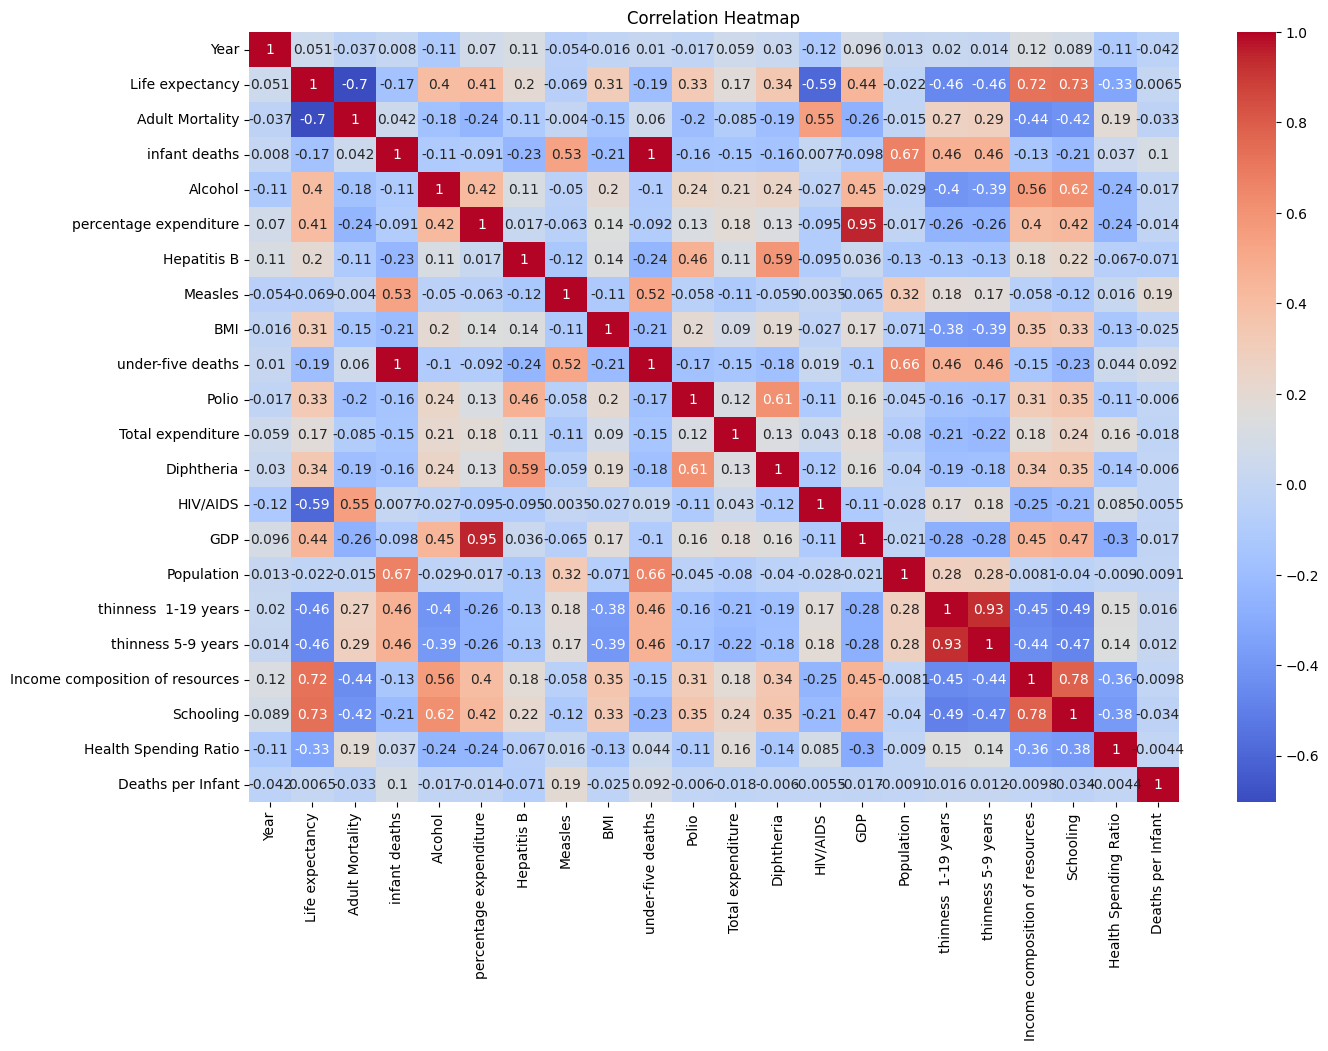

In [30]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

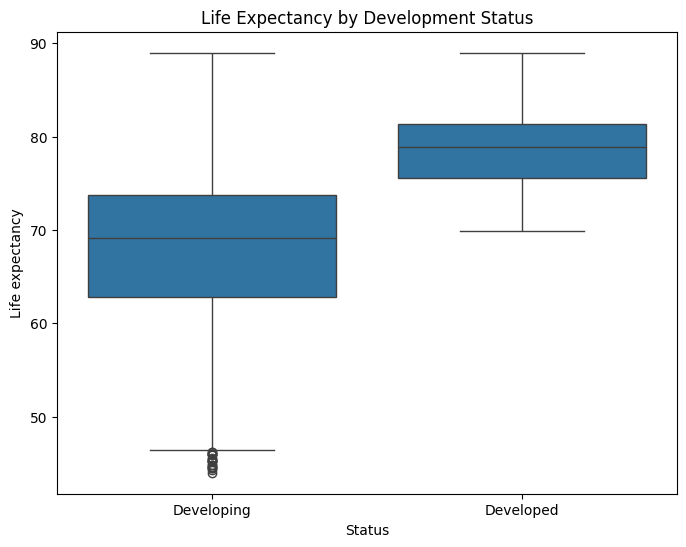

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Status', y='Life expectancy', data=df)
plt.title('Life Expectancy by Development Status')
plt.show()

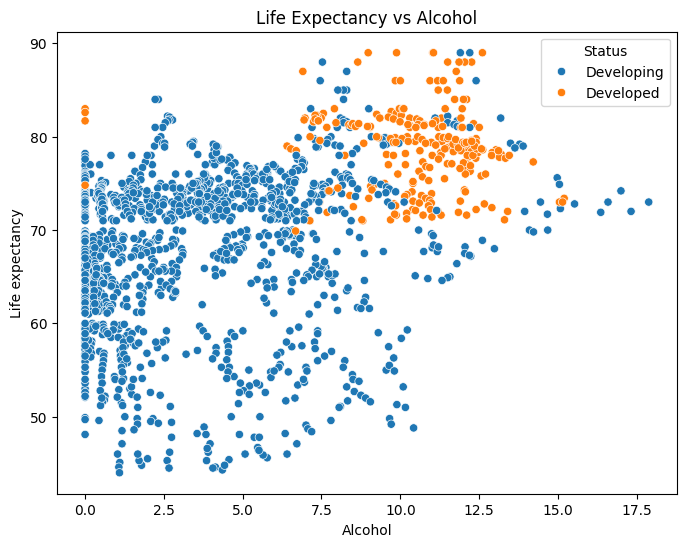

In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Alcohol', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Alcohol')
plt.show()

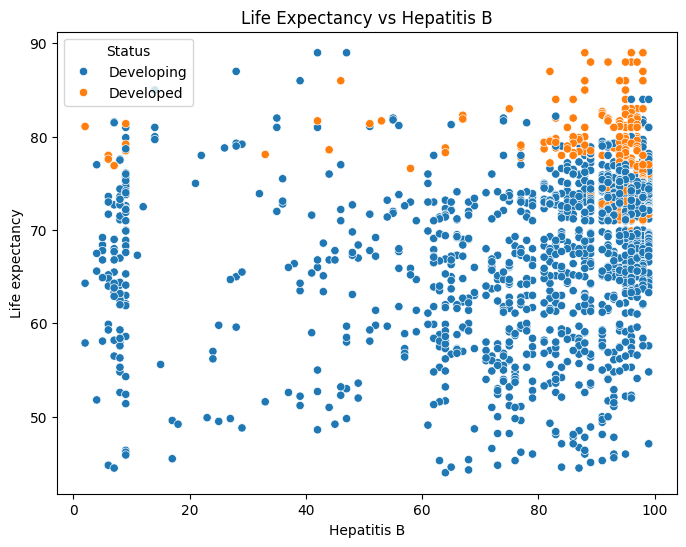

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Hepatitis B', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Hepatitis B')
plt.show()

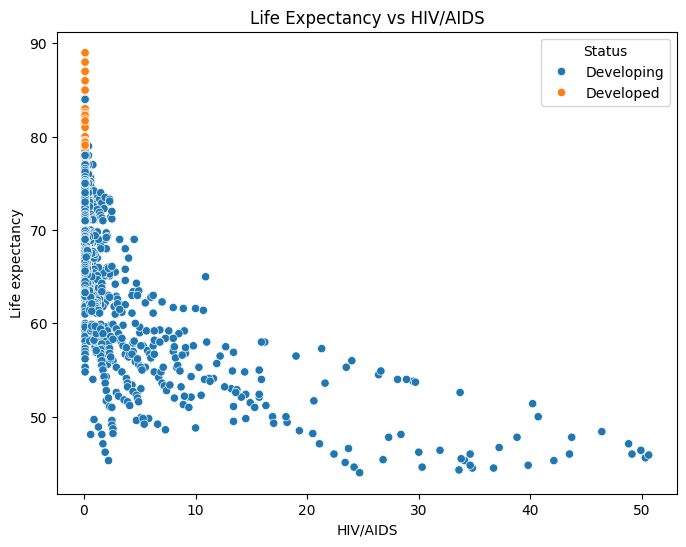

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='HIV/AIDS', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs HIV/AIDS')
plt.show()

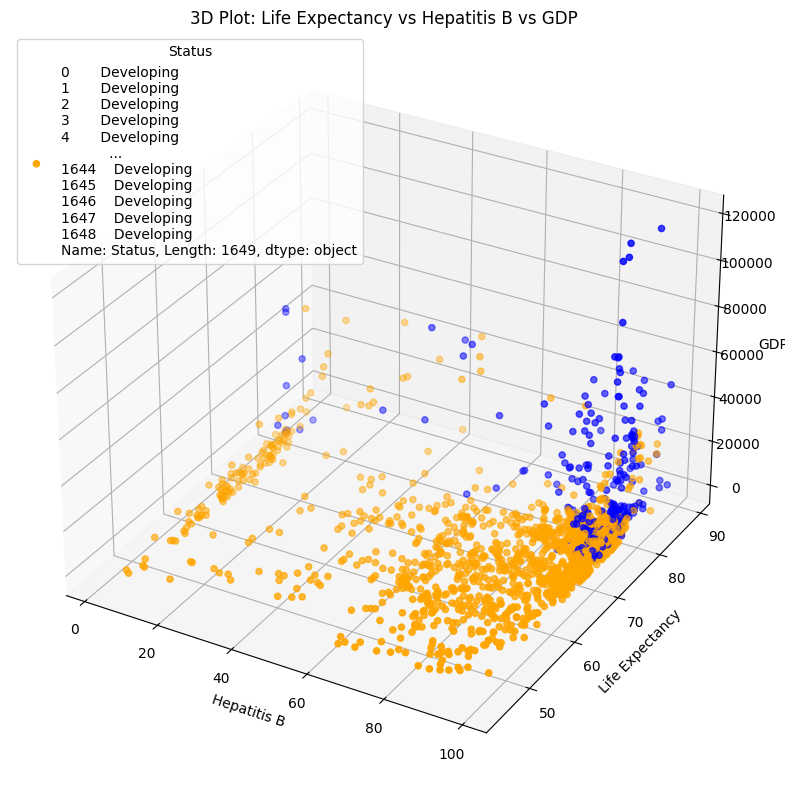

In [ ]:
#3D plot for Life Expectancy vs Hepatitis B vs GDP
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = {'Developed': 'blue', 'Developing': 'orange'}
status_colors = df['Status'].map(colors)
ax.scatter(
    df['Hepatitis B'],
    df['Life expectancy'],
    df['GDP'],
    c=status_colors,
    label=df['Status']
)
ax.set_xlabel('Hepatitis B')
ax.set_ylabel('Life Expectancy')
ax.set_zlabel('GDP')
ax.set_title('3D Plot: Life Expectancy vs Hepatitis B vs GDP')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9116\2029657473.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  country_cmap = plt.cm.get_cmap('tab20', df_clean['CountryCode'].nunique())


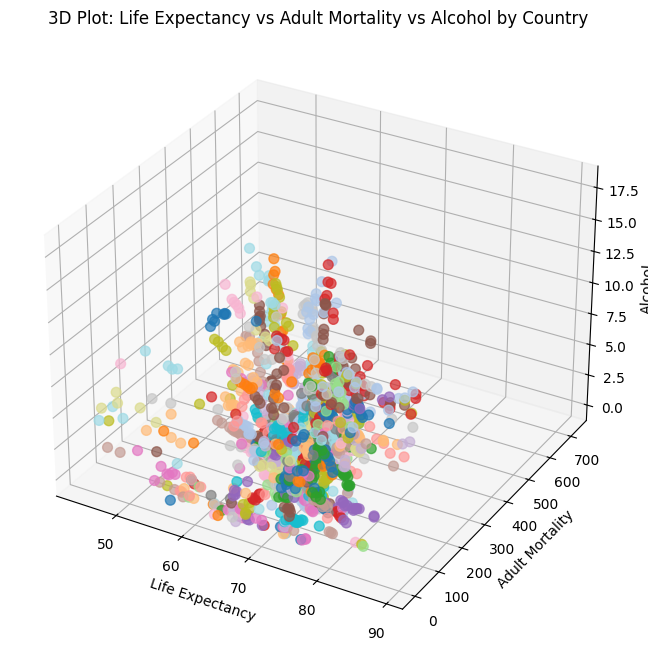

In [36]:
df_clean = df.dropna(subset=['Life expectancy', 'Adult Mortality', 'Alcohol', 'Country'])
df_clean['CountryCode'] = df_clean['Country'].astype('category').cat.codes
country_cmap = plt.cm.get_cmap('tab20', df_clean['CountryCode'].nunique())
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df_clean['Life expectancy'],
    df_clean['Adult Mortality'],
    df_clean['Alcohol'],
    c=df_clean['CountryCode'],
    cmap=country_cmap,
    alpha=0.7,
    s=50
)
ax.set_xlabel('Life Expectancy')
ax.set_ylabel('Adult Mortality')
ax.set_zlabel('Alcohol')
plt.title('3D Plot: Life Expectancy vs Adult Mortality vs Alcohol by Country')
plt.show()

### Task 9: Interpretation
- Higher GDP and schooling are associated with higher life expectancy.
- Developing countries tend to have more outliers and lower average life expectancy.
- HIV/AIDS has a strong negative correlation with life expectancy.

### Task 10: Data Splitting and Model Training

In [37]:
features = ['GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']
X = df[features]
y = df['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Task 11: Cross Validation and Model Evaluation

In [38]:
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
cross_val = cross_val_score(model, X, y, cv=5).mean()
mae, r2, cross_val

(3.558518589894625, 0.7164135867990629, np.float64(0.6993796855845831))

### Task 12: Conclusion and Recommendations
- **Key Findings**: Life expectancy is positively influenced by GDP, schooling, and healthcare access. HIV/AIDS is a major negative predictor.
- **Model Performance**: The linear model gives reasonable accuracy with cross-validation.
- **Recommendation**: Focus on improving education, economic stability, and healthcare to raise life expectancy.